# Calculate the four-terminal conductance of Twisted Bilayer Graphene devices with either zigzag or armchair graphene boundaries

In [1]:
#********************************************** Importing modules **********************************************#

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, exp, cos, pi, sqrt
from shapely.geometry import Point, Polygon
import kwant
import copy
import timeit
import datetime

#********************************************** Defining constants **********************************************#

sin_30, cos_30 = (1. / 2, sqrt(3.) / 2) 
a0 = 2.46 # Honeycomb lattice constant (not nearest-neighbors!) [A]
d0 = 3.35 # Distance between the layers [A]
lcon = a0 / sqrt(3) # Nearest neighbor constant [A]
R0 = a0 * cos_30 + lcon * sin_30 + lcon # Lattice constant with armchair edges
Vppp = 3.09 # Intralayer hopping for graphene [eV]
Vpps =  0.39 # Interlayer hopping for AA stacked Bilayer graphene[eV]
chem_pot = 2 # Chemical potential of the leads
lambda0 = 0.27 # Constant necessary for the interlayer hoppings[A]

In [2]:
#********************************************* Auxiliary functions *********************************************#

def parallelogram(L,W, trans = np.array([0,0])):
    
    """ Create a parallelogram.
    
    Parameters:
    -----------
    v1, v2: Numpy arrays
        sides of the parallelogram
    trans: NumPy array
        position of the bottom left corner of the parallelogram
    return_coords: Bool
        if set to True the coordinates of the parallelogram are the second output
        
    Returns:
    --------
    poly: Shapely polygon
        Polygon of the parallelogram
    coords: NumPy array
        Optional output, coordinates of the vertices of the parallelogram
    """
    
    coords  = np.array( [trans, trans + np.array([L,0]), 
                         trans + np.array([L + W * sin_30, W * cos_30]), trans + np.array([W * sin_30, W * cos_30])])
    xs, ys = [], []   
    poly = Polygon(coords)
    return poly

def rotate(angle, vector):
    '''
        Returns a rotated 3D vector around the z-axis 
    '''
    M = np.array([
        [cos(angle),-sin(angle),0],
        [sin(angle),cos(angle),0],
        [0,0,1]
    ])
    return M @ vector

def distance(site1, site2): 
    '''
        Returns the distance between two kwant site objects
    '''
    x1,y1,z1 = site1.pos
    x2,y2,z2 = site2.pos
    sq = (x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2-z1) ** 2
        
    return sqrt(sq)

def interlayer_hopping(dist):
    '''
        Returns the interlayer hopping amplitude given the distance between two sites
    '''
    ex = exp(- (dist - d0) / lambda0) 
    
    return Vpps * ex * d0 * d0 / (dist ** 2)

def get_commensurate_angles(q = 1, N = 1, print_angles = True):
    '''
        Returns N commensurate angles (in degrees) of TBG, from highest to lowest                         
    '''
    
    angles = []
    for p in range(N):
        p += 1
        num = 3*p*p + 3*p*q + q*q/2
        denom = 3*p*p + 3*p*q + q*q
        angles.append(np.degrees(np.arccos(num / denom)))
    if print_angles:
        for angle in angles:
            print(angle, end = ', ')
    return(angles)

def check_kwargs(necessary_kwargs, **kwargs):
    
    '''
        Evaluates if the kwargs include necessary parameters for auxiliary and/or nested functions                       
    '''
    
    kwargs_missing_string = ''
    
    for kwarg in necessary_kwargs:
        if kwarg not in kwargs:
            
            kwargs_missing_string = kwargs_missing_string + kwarg + ', '
        
    if len(kwargs_missing_string) > 0 :
        
        raise KeyError('The following parameters are required: ' + kwargs_missing_string[0:-2])


/home/aleksander/anaconda3/lib/python3.8/site-packages/kwant/_plotter.py:312: RuntimeWarning: divide by zero encountered in double_scalars
  return -self.zorder3d + vs[2].mean() / cz.ptp()


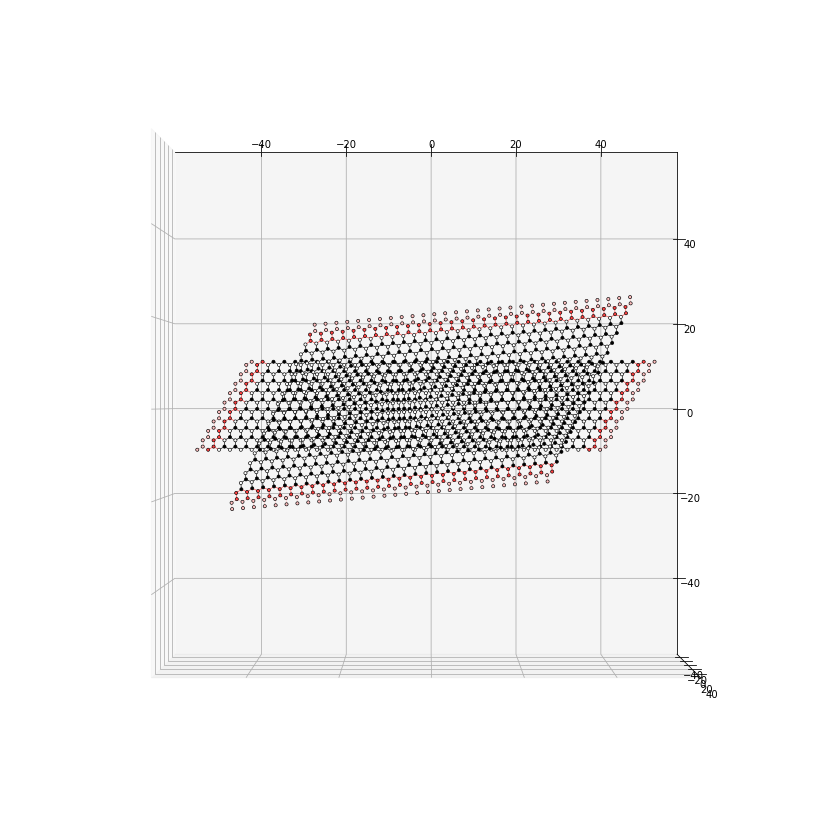

Timer: 0:00:08


array([[ 1.24340124, -0.96391547, -0.239434  , -0.04005178],
       [-0.96391547,  2.82990739, -1.5221647 , -0.34382723],
       [-0.239434  , -1.5221647 ,  2.84969164, -1.08809294],
       [-0.04005178, -0.34382723, -1.08809294,  1.47197195]])

In [3]:
#****************************** Functions to generate the samples as kwant systems ******************************#

#************************************* Cross-conductance with zigzag edges *************************************#

def TBG_conductance_cross_zigzag(NLb=1, NWb=1,NLt=1,NWt=1,stacking = "AA", Nx = 1, Ny = 1, theta = 0,\
                                 single_layer_leads = False,show_lattice = False, cutoff=5, energy = 0.0001,\
                                 timer=False):
    '''
        Calculate the conductance matrix Gij of a TBG sample of graphene layers with zigzag termination.
        
        Parameters: NLb,NLt (NWb, NWt): float
                        graphene translation in length (width) of the bottom and top layers
                    stacking: 'AA' or 'AB'
                        stacking of the layers when not rotated 
                    Nx, Ny: int
                        number of divisions of the sample in length (Nx) and width (Ny). 
                        Example: Nx = 2, Ny = 10 means 20 subsections. Creating parallelograms
                        of around 7x7A was generally good for performance and did not affect the 
                        outcome.
                    theta: float
                        relative rotation of the graphene layers
                    single_layer_leads: bool
                        if True only the bottom (unrotated) layer of graphene is attached to a
                        pair of leads. If False the top layer is connected to a pair of leads 
                        transversal to the first pair
                    show_lattice: bool
                        plot the lattice 
                    cutoff: float
                        the cutoff of the interlayer hoppings
                    energy: float
                        energy of electrons 
                    timer: bool
                        print the timer of the calculations
                   
        Returns:    conductance_matrix: NumPy array
                        conductance matrix with the following shape 
                            Gij = np.array(
                                            [[G01+G02+G03,-G01,-G02,-G03],
                                             [-G10,G10+G12+G13,-G12,-G13],
                                             [-G20,-G21,G20+G21+G23,-G23],
                                             [-G30,-G31,-G32,G30+G31+G32]]
                                           )
                        The number of the leads is determined by the order in which they were
                        attached (notice that the numbering is different here from the one in 
                        the manuscript!)
                                
    '''
        
    start = timeit.default_timer()

    theta = np.radians(theta)
    
    #********************************** Creating the bulk of the lattice **********************************#
    
    V1_bot = a0 * np.array([1, 0, 0]) # Primitive vectors
    V2_bot = a0 * np.array([sin_30,cos_30, 0])

    V1_top = rotate(theta,V1_bot)
    V2_top = rotate(theta,V2_bot)
    
    bot_lat = kwant.lattice.general([V1_bot,V2_bot],
                                     [(0,0,0),(0,lcon,0)],
                                     norbs=1)
    ab, bb = bot_lat.sublattices
    
    v1 = np.array([0,0,d0])
    
    if stacking == "AB":
        v1 += (V1_bot + np.array([0,lcon,0])) / 2
        
    top_lat = kwant.lattice.general([V1_top,V2_top],
                                     [v1, v1 + rotate(theta,[0,lcon,0])],
                                     norbs=1)
    at, bt = top_lat.sublattices
    
    syst = kwant.Builder()
    bot_lead = kwant.Builder(kwant.TranslationalSymmetry(-V1_bot))
    top_lead = kwant.Builder(kwant.TranslationalSymmetry(-V2_top))
    
    #****************************************** Adding the sites ******************************************#    
    
    NLbs = -int(NLb / 2)
    NWbs = -int(NWb / 2)
    NLts = -int(NLt / 2)
    NWts = -int(NWt / 2)
    
    for j in range(NWb):
        
        bot_lead[ab(NLbs,j+NWbs)] = -chem_pot
        bot_lead[bb(NLbs,j+NWbs)] = -chem_pot
        
        for i in range(NLb):
            
            syst[ab(i+NLbs,j+NWbs)] = 0
            syst[bb(i+NLbs,j+NWbs)] = 0  

    del bot_lead[ab(NLbs,NWbs)]
    bot_lead[ab(NLbs,NWb+NWbs)] = -chem_pot
    
    for i in range(NLb):
        
        del syst[ab(i+NLbs,NWbs)]
        syst[ab(i+NLbs,NWb+NWbs)] = 0    
        
    for i in range(NLt):
        
        top_lead[at(NLts+i,NWts)] = -chem_pot
        top_lead[bt(NLts+i,NWts)] = -chem_pot
        
        for j in range(NWt):
            
            syst[at(i+NLts,j+NWts)] = 0
            syst[bt(i+NLts,j+NWts)] = 0  
    
    for i in range(NLt):
        
        del syst[at(i+NLts,NWts)]
        syst[at(i+NLts,NWt+NWts)] = 0

    #************************************* Adding intralayer hoppins *************************************#
    
    syst[bot_lat.neighbors()] = -Vppp
    bot_lead[bot_lat.neighbors()] = -Vppp
    syst[top_lat.neighbors()] = -Vppp
    top_lead[top_lat.neighbors()] = -Vppp
    
    #**************************************** Attaching the leads ****************************************#
    
    if single_layer_leads: 
        
        syst.attach_lead(bot_lead); # Lead 0
        syst.attach_lead(bot_lead.reversed()); # Lead 1
        
    else:
        
        syst.attach_lead(bot_lead); # Lead 0
        syst.attach_lead(top_lead); # Lead 1
        syst.attach_lead(top_lead.reversed()); # Lead 2
        syst.attach_lead(bot_lead.reversed()); # Lead 3

    #********************************************** Plotting **********************************************#

    if show_lattice == True:
        
        azim, dist, elev = -90, 10, 90 # Default: -60, 10, 30, View from above: -90, 10, 90
        fig = plt.figure(figsize=(15,15))
        ax = fig.gca(projection='3d')
        ax.azim = azim
        ax.dist = dist
        ax.elev = elev             
        
        def site_color(site):
            
            if site.family == ab or site.family == at:
                return 'black'
            else:
                return 'white'
        
        kwant.plot(syst,site_size = 0.25,site_color=site_color,hop_lw = 0.1,ax = ax);
        plt.show()
        plt.close()
    
    #******************************** Dividing the sample into subdomains ********************************#

    sites = list(syst.sites())
    top_sites = []
    bot_sites = []
    
    for site in sites:
        x,y,z = site.pos
        if z == 0:
            bot_sites.append(site)
        else:
            top_sites.append(site)

            
    domains_bot = []
    domains_top = []
    
    Lb = NLb * a0
    Wb = NWb * a0
    
    for j in range(Ny+2):
        for i in range(Nx+2):
            
            trans = np.array([ Lb  / Nx * (i-1) + Wb / Ny * (j-1) * sin_30  - Lb / 2 - (Wb * sin_30 / 2) - (cutoff / 2),
                                               Wb / Ny * (j-1) - (Wb * cos_30 / 2) - (cutoff / 2)])
            
            poly = parallelogram( Lb / Nx + cutoff , Wb / Ny + cutoff,trans = trans)

            temp_bot = []
            temp_top = []
            
            for site in sites:
                x,y,z = site.pos
                pt = Point([x,y])
                if pt.within(poly):
                    if z == 0:
                        temp_bot.append(site)
                    else:
                        temp_top.append(site)
                        
            domains_bot.append(temp_bot)
            domains_top.append(temp_top)
            
    #*********************************** Adding the intralayer hoppings ***********************************#
    
    for i,domain_bot in enumerate(domains_bot):
        for site1 in domain_bot:
            for site2 in domains_top[i]:
                dist = distance(site1,site2)
                syst[site1,site2] = -interlayer_hopping(dist)    
                    
    #************************** Finalizing and extracting the conductance matrix **************************#
    
    systf = syst.finalized()
    smatrix = kwant.smatrix(systf, energy)
    conductance_matrix = smatrix.conductance_matrix()
    
    if timer:
        print('Timer: {}'.format(str(datetime.timedelta(seconds = int(timeit.default_timer() - start)))))
        
    return conductance_matrix

#*************************************************** Testing ***************************************************#  

TBG_conductance_cross_zigzag(NLb=34, NWb=10,NLt=30,NWt=14,stacking = "AB", Nx = 3, Ny = 10, theta = 5,\
                          single_layer_leads = False,show_lattice = True, cutoff=5, energy = 0.0001,timer=True)

/home/aleksander/anaconda3/lib/python3.8/site-packages/kwant/_plotter.py:312: RuntimeWarning: divide by zero encountered in double_scalars
  return -self.zorder3d + vs[2].mean() / cz.ptp()


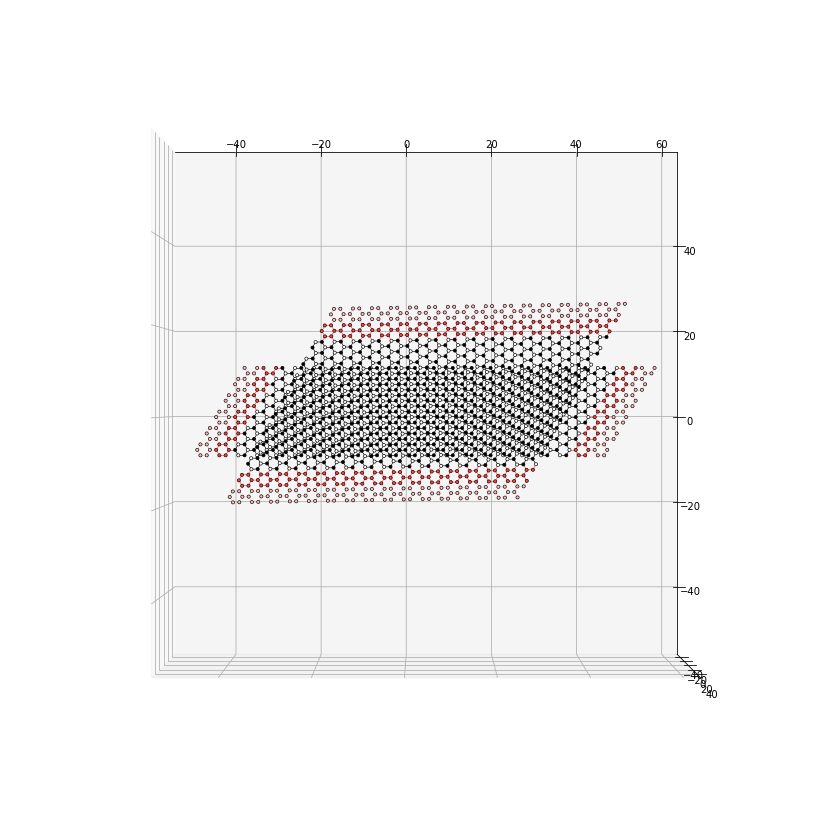

array([[ 0.96429371, -0.30109295, -0.26424482, -0.39895593],
       [-0.30109295,  1.74887113, -1.22226919, -0.22550899],
       [-0.26424482, -1.22226919,  1.76992119, -0.28340718],
       [-0.39895593, -0.22550899, -0.28340718,  0.9078721 ]])

In [4]:
#************************************ Cross-conductance with armchair edges ************************************#

def TBG_conductance_cross_armchair(NLb=1, NWb=1, NLt=1, NWt=1, stacking = "AA", Nx = 1, Ny = 1, cutoff=5, theta = 0,\
                                   single_layer_leads = False, metallic = True, show_lattice = False, energy = 0.0001, timer=False):
    
    '''
        Calculate the conductance matrix Gij of a TBG sample with graphene layers of armchair termination.
        
        Parameters: NLb,NLt (NWb, NWt): float
                        armchair graphene translation (length R0 not a0!) in length (width) of the bottom and top layers
                    stacking: 'AA' or 'AB'
                        stacking of the layers when not rotated 
                    Nx, Ny: int
                        number of divisions of the sample in length (Nx) and width (Ny). 
                        Example: Nx = 2, Ny = 10 means 20 subsections. Creating parallelograms
                        of around 7x7A was generally good for performance and did not affect the 
                        outcome.
                    theta: float
                        relative rotation of the graphene layers
                    single_layer_leads: bool
                        if True only the bottom (unrotated) layer of graphene is attached to a
                        pair of leads. If False the top layer is connected to a pair of leads 
                        transversal to the first pair
                    metallic: bool
                        if set to True it adds a few sites to the sample that makes the spectrum semi-metallic (gapless)
                    show_lattice: bool
                        plot the lattice 
                    cutoff: float
                        the cutoff of the interlayer hoppings
                    energy: float
                        energy of electrons 
                    timer: bool
                        print the timer of the calculations
                   
        Returns:    conductance_matrix: NumPy array
                        conductance matrix with the following shape 
                            Gij = np.array(
                                            [[G01+G02+G03,-G01,-G02,-G03],
                                             [-G10,G10+G12+G13,-G12,-G13],
                                             [-G20,-G21,G20+G21+G23,-G23],
                                             [-G30,-G31,-G32,G30+G31+G32]]
                                           )
                        The number of the leads is determined by the order in which they were
                        attached (notice that the numbering is different here from the one in 
                        the manuscript!)
                                
    '''
    
    
    start = timeit.default_timer()

    #********************************** Creating the bulk of the lattice **********************************#
            
    theta = np.radians(theta)
    
    a1 = np.array([0,0,0])
    a2 = np.array([sin_30,-cos_30,0]) * lcon
    a3 = np.array([cos_30,-sin_30,0]) * a0
    a4 = np.array([1,0,0]) * (R0 - lcon)
    a5 = np.array([cos_30,sin_30,0]) * a0
    a6 = np.array([sin_30,cos_30,0]) * lcon
    
    bot_basis = [a1,a2,a3,a4,a5,a6]
    
    V1_bot = R0 * np.array([1, 0, 0]) # Primitive vectors
    V2_bot = R0 * np.array([sin_30,cos_30, 0])
    V1_top = rotate(theta,V1_bot)
    V2_top = rotate(theta,V2_bot)
    
    bot_lat = kwant.lattice.general([V1_bot,V2_bot],
                                     bot_basis,
                                     norbs=1)
    
    v1 = np.array([0,0,d0])
    
    if stacking == "AB":
        v1 += np.array([lcon*sin_30,lcon*cos_30,0])
        
    top_basis = []
    
    for atom in bot_basis:
        top_basis.append(rotate(theta,atom) + v1)  
        
    top_lat = kwant.lattice.general([V1_top,V2_top],
                                     top_basis,
                                     norbs=1)
    
    syst = kwant.Builder()
    bot_lead = kwant.Builder(kwant.TranslationalSymmetry(-V1_bot))
    top_lead = kwant.Builder(kwant.TranslationalSymmetry(-V2_top))
    
    ab,bb,cb,db,eb,fb = bot_lat.sublattices
    at,bt,ct,dt,et,ft = top_lat.sublattices
    
    #****************************************** Adding the sites ******************************************#    
    
    NLbs = -int(NLb / 2)
    NWbs = -int(NWb / 2)
    NLts = -int(NLt / 2)
    NWts = -int(NWt / 2)
    
    for j in range(NWb):
        
        bot_lead[ab(NLbs,j+NWbs)] = -chem_pot
        bot_lead[bb(NLbs,j+NWbs)] = -chem_pot
        bot_lead[cb(NLbs,j+NWbs)] = -chem_pot
        bot_lead[db(NLbs,j+NWbs)] = -chem_pot
        bot_lead[eb(NLbs,j+NWbs)] = -chem_pot
        bot_lead[fb(NLbs,j+NWbs)] = -chem_pot
        
        for i in range(NLb):
            
            syst[ab(i+NLbs,j+NWbs)] = 0
            syst[bb(i+NLbs,j+NWbs)] = 0  
            syst[cb(i+NLbs,j+NWbs)] = 0
            syst[db(i+NLbs,j+NWbs)] = 0 
            syst[eb(i+NLbs,j+NWbs)] = 0
            syst[fb(i+NLbs,j+NWbs)] = 0         
        
    for i in range(NLt):
        
        top_lead[at(NLts+i,NWts)] = -chem_pot
        top_lead[bt(NLts+i,NWts)] = -chem_pot
        top_lead[ct(NLts+i,NWts)] = -chem_pot
        top_lead[dt(NLts+i,NWts)] = -chem_pot
        top_lead[et(NLts+i,NWts)] = -chem_pot
        top_lead[ft(NLts+i,NWts)] = -chem_pot
        
        for j in range(NWt):
            
            syst[at(i+NLts,j+NWts)] = 0
            syst[bt(i+NLts,j+NWts)] = 0  
            syst[ct(i+NLts,j+NWts)] = 0
            syst[dt(i+NLts,j+NWts)] = 0 
            syst[et(i+NLts,j+NWts)] = 0
            syst[ft(i+NLts,j+NWts)] = 0 
    
    if metallic:
        
        for i in range(NLb):

            syst[bb(i + NLbs,NWb + NWbs)] = 0
            syst[cb(i + NLbs,NWb + NWbs)] = 0
            syst[ab(i + NLbs,NWb + NWbs)] = 0
            syst[db(i + NLbs,NWb + NWbs)] = 0 
            
        for j in range(NWb):
        
            syst[ab(NLb + NLbs,j + NWbs)] = 0
            syst[bb(NLb + NLbs,j + NWbs)] = 0
            syst[eb(NLb + NLbs,j + NWbs)] = 0
            syst[fb(NLb + NLbs,j + NWbs)] = 0

        bot_lead[bb( NLbs,NWb + NWbs)] = -chem_pot
        bot_lead[cb( NLbs,NWb + NWbs)] = -chem_pot
        bot_lead[ab( NLbs,NWb + NWbs)] = -chem_pot
        bot_lead[db( NLbs,NWb + NWbs)] = -chem_pot


        for j in range(NWt):

            syst[bt(NLt + NLts,j + NWts)] = 0
            syst[et(NLt + NLts,j + NWts)] = 0
            syst[at(NLt + NLts,j + NWts)] = 0
            syst[ft(NLt + NLts,j + NWts)] = 0
            
        for i in range(NLt):

            syst[bt(i + NLts,NWt + NWts)] = 0
            syst[ct(i + NLts,NWt + NWts)] = 0
            syst[at(i + NLts,NWt + NWts)] = 0
            syst[dt(i + NLts,NWt + NWts)] = 0

        top_lead[bt(NLt + NLts, NWts)] = -chem_pot
        top_lead[et(NLt + NLts, NWts)] = -chem_pot
        top_lead[at(NLt + NLts, NWts)] = -chem_pot
        top_lead[ft(NLt + NLts, NWts)] = -chem_pot

    #************************************ Adding intralayer hoppings *************************************#

    syst[bot_lat.neighbors()] = -Vppp
    bot_lead[bot_lat.neighbors()] = -Vppp
    syst[top_lat.neighbors()] = -Vppp
    top_lead[top_lat.neighbors()] = -Vppp
    
    #**************************************** Attaching the leads ****************************************#
    
    if single_layer_leads:
        
        syst.attach_lead(bot_lead); # Lead 0 
        syst.attach_lead(bot_lead.reversed()); # Lead 1
    else:
        syst.attach_lead(bot_lead); # Lead 0
        syst.attach_lead(top_lead); # Lead 1
        syst.attach_lead(top_lead.reversed()); # Lead 2
        syst.attach_lead(bot_lead.reversed()); # Lead 3
        
    #********************************************** Plotting **********************************************#
    
    if show_lattice == True:
        
        azim, dist, elev = -90, 10, 90 # Default: -60, 10, 30, View from above: -90, 10, 90
        fig = plt.figure(figsize=(15,15))
        ax = fig.gca(projection='3d')
        ax.azim = azim
        ax.dist = dist
        ax.elev = elev             
        
        def site_color(site):
            
            if site.family == ab or site.family == cb or site.family == eb or site.family == at or site.family == ct or site.family == et:
                return 'black'
            else:
                return 'white'
        
        kwant.plot(syst,site_size = 0.25,site_color=site_color,hop_lw = 0.1,ax = ax);
        plt.show()
        plt.close()
        
    #******************************** Dividing the sample into subdomains ********************************#
    
    sites = list(syst.sites())
    top_sites = []
    bot_sites = []
    
    for site in sites:
        x,y,z = site.pos
        if z == 0:
            bot_sites.append(site)
        else:
            top_sites.append(site)

            
    domains_bot = []
    domains_top = []
    
    Lb = NLb * R0
    Wb = NWb * R0
    
    for j in range(Ny+2):
        for i in range(Nx+2):
            
            trans = np.array([ Lb  / Nx * (i-1) + Wb / Ny * (j-1) * sin_30  - Lb / 2 - (Wb * sin_30 / 2) - (cutoff / 2),
                                               Wb / Ny * (j-1) - (Wb * cos_30 / 2) - (cutoff / 2)])
            
            poly = parallelogram( Lb / Nx + cutoff , Wb / Ny + cutoff ,
                             trans = trans)

            temp_bot = []
            temp_top = []
            
            for site in sites:
                x,y,z = site.pos
                pt = Point([x,y])
                if pt.within(poly):
                    if z == 0:
                        temp_bot.append(site)
                    else:
                        temp_top.append(site)
                        
            domains_bot.append(temp_bot)
            domains_top.append(temp_top)
            
    #*********************************** Adding the intralayer hoppings ***********************************#
    
    for i,domain_bot in enumerate(domains_bot):

        for site1 in domain_bot:
            for site2 in domains_top[i]:
                dist = distance(site1,site2)
                syst[site1,site2] = -interlayer_hopping(dist)  
    
    
    #************************** Finalizing and extracting the conductance matrix **************************#
    
    systf = syst.finalized()
    smatrix = kwant.smatrix(systf, energy)

    conductance_matrix = smatrix.conductance_matrix()
    
    if timer:
        print('Timer: {}'.format(str(datetime.timedelta(seconds = int(timeit.default_timer() - start)))))
    
    return conductance_matrix

#*************************************************** Testing ***************************************************#  

TBG_conductance_cross_armchair(NLb=17, NWb= 5,NLt=15,NWt=7,stacking = "AB", Nx = 3, Ny = 2, cutoff=4,
                               theta = 1,single_layer_leads = False, metallic = True,
                               show_lattice = True, energy = 0.0001,timer=False)

In [5]:
#********************************** Creating the bulk of the lattice **********************************#
#****************************************** Adding the sites ******************************************#
#************************************ Adding intralayer hoppings *************************************#
#**************************************** Attaching the leads ****************************************#
#********************************************** Plotting **********************************************#
#******************************** Dividing the sample into subdomains ********************************#
#*********************************** Adding the intralayer hoppings ***********************************#
#************************** Finalizing and extracting the conductance matrix **************************#

/home/aleksander/anaconda3/lib/python3.8/site-packages/kwant/_plotter.py:312: RuntimeWarning: divide by zero encountered in double_scalars
  return -self.zorder3d + vs[2].mean() / cz.ptp()


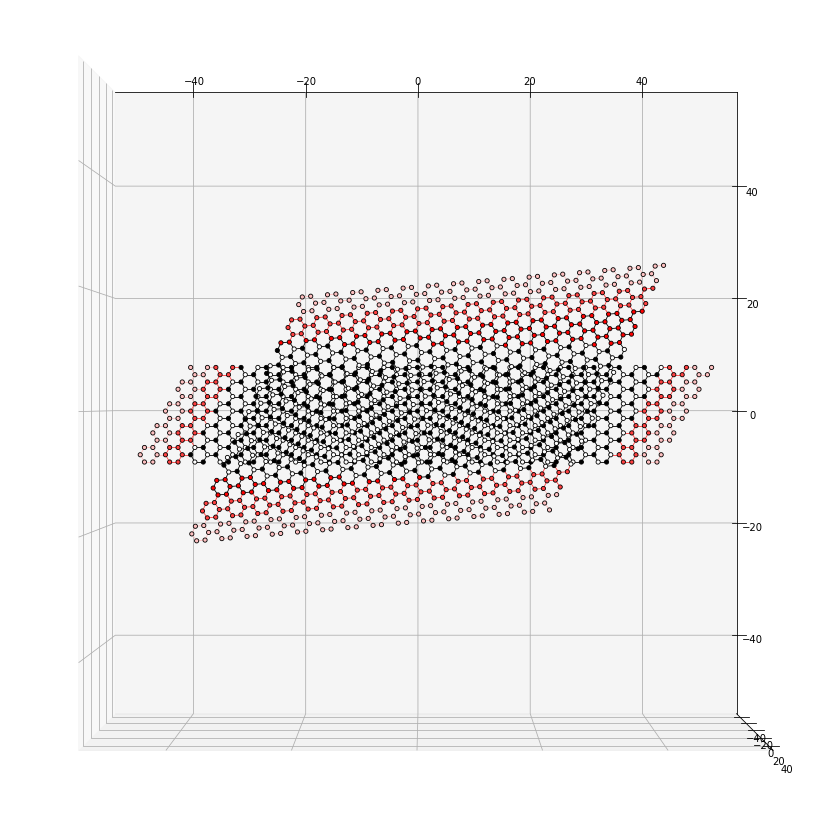

Timer: 0:00:06


array([[ 0.99351264, -0.20118901, -0.21731981, -0.57500383],
       [-0.20118901,  1.9642224 , -1.61894192, -0.14409147],
       [-0.21731981, -1.61894192,  2.13010442, -0.2938427 ],
       [-0.57500383, -0.14409147, -0.2938427 ,  1.012938  ]])

In [6]:
#********************* Cross-conductance with armchair edges and constant distance to leads *********************#

def TBG_conductance_cross_armchair_constant_chempot(NLb=1, NWb=1,NLt=1,NWt=1,stacking = "AA", Nx = 1, Ny = 1, theta = 0,\
                                                    metallic = True, show_lattice = False, cutoff=5, energy = 0.0001,timer=False):
    
    '''
        Calculate the conductance matrix Gij of a TBG sample with graphene layers of armchair termination and a constand distance 
        from the scattering region to the leads attached (we accomplish this by adding extra sites with the same chemical potential
        as the leads).
        
        Parameters: NLb,NLt (NWb, NWt): float
                        armchair graphene translations (length R0 not a0!) in length (width) of the bottom and top layers
                    stacking: 'AA' or 'AB'
                        stacking of the layers at theta = 0 
                    Nx, Ny: int
                        number of divisions of the sample in length (Nx) and width (Ny). 
                        Example: Nx = 2, Ny = 10 means 20 subsections. Creating parallelograms
                        of around 7x7A was generally good for performance and did not affect the 
                        outcome.
                    theta: float
                        relative rotation of the graphene layers
                    metallic: bool
                        if set to True it adds a few sites to the sample that makes the spectrum semi-metallic (gapless)
                    show_lattice: bool
                        plot the lattice 
                    cutoff: float
                        the cutoff of the interlayer hoppings
                    energy: float
                        energy of electrons 
                    timer: bool
                        print the timer of the calculations
                   
        Returns:    conductance_matrix: NumPy array
                        conductance matrix with the following shape 
                            Gij = np.array(
                                            [[G01+G02+G03,-G01,-G02,-G03],
                                             [-G10,G10+G12+G13,-G12,-G13],
                                             [-G20,-G21,G20+G21+G23,-G23],
                                             [-G30,-G31,-G32,G30+G31+G32]]
                                           )
                        The number of the leads is determined by the order in which they were
                        attached (notice that the numbering is different here from the one in 
                        the manuscript!)
                                
    '''
    
    start = timeit.default_timer()

    #********************************** Creating the bulk of the lattice **********************************#
            
    theta = np.radians(theta)
    
    a1 = np.array([0,0,0])
    a2 = np.array([sin_30,-cos_30,0]) * lcon
    a3 = np.array([cos_30,-sin_30,0]) * a0
    a4 = np.array([1,0,0]) * (R0 - lcon)
    a5 = np.array([cos_30,sin_30,0]) * a0
    a6 = np.array([sin_30,cos_30,0]) * lcon
    
    bot_basis = [a1,a2,a3,a4,a5,a6]
    
    V1_bot = R0 * np.array([1, 0, 0]) # Primitive vectors
    V2_bot = R0 * np.array([sin_30,cos_30, 0])
    V1_top = rotate(theta,V1_bot)
    V2_top = rotate(theta,V2_bot)

    v1 = np.array([0,0,d0])
    
    if stacking == "AB":
        v1 += np.array([lcon*sin_30,lcon*cos_30,0])
        
    top_basis = []
    for atom in bot_basis:
        top_basis.append(rotate(theta,atom) + v1)  
        
    bot_lat = kwant.lattice.general([V1_bot,V2_bot],bot_basis,norbs=1)    
    top_lat = kwant.lattice.general([V1_top,V2_top],top_basis,norbs=1)
    
    syst = kwant.Builder()
    bot_lead = kwant.Builder(kwant.TranslationalSymmetry(-V1_bot))
    top_lead = kwant.Builder(kwant.TranslationalSymmetry(-V2_top))
    
    #****************************************** Adding the sites ******************************************#
    
    NLbs = -int(NLb / 2)
    NWbs = -int(NWb / 2)
    NLts = -int(NLt / 2)
    NWts = -int(NWt / 2)
    
    ab,bb,cb,db,eb,fb = bot_lat.sublattices
    at,bt,ct,dt,et,ft = top_lat.sublattices
    
    for j in range(NWb):
        
        bot_lead[ab(NLbs,j+NWbs)] = -chem_pot
        bot_lead[bb(NLbs,j+NWbs)] = -chem_pot
        bot_lead[cb(NLbs,j+NWbs)] = -chem_pot
        bot_lead[db(NLbs,j+NWbs)] = -chem_pot
        bot_lead[eb(NLbs,j+NWbs)] = -chem_pot
        bot_lead[fb(NLbs,j+NWbs)] = -chem_pot
        
        for i in range(NLb):
            
            syst[ab(i+NLbs,j+NWbs)] = 0
            syst[bb(i+NLbs,j+NWbs)] = 0  
            syst[cb(i+NLbs,j+NWbs)] = 0
            syst[db(i+NLbs,j+NWbs)] = 0 
            syst[eb(i+NLbs,j+NWbs)] = 0
            syst[fb(i+NLbs,j+NWbs)] = 0 
            
            
    ymin = -lcon * cos_30 + v1[1] + (NWts * R0 * cos_30)
    ymax = -ymin
    
    displacement = at(NLts,NWt + NWts).pos
    displacement = np.array(displacement)
    ydif = ymax - displacement[1]
    extra_translations = int(ydif / (R0 * cos_30))

    NWts += - extra_translations
    NWt += 2 *  extra_translations
    
    def chem_potential(site):
        x,y,z = site.pos
        if y >= ymin and y <= ymax:
            return 0
        else:
            return -chem_pot
        
    for i in range(NLt):
        
        top_lead[at(NLts+i,NWts)] = -chem_pot
        top_lead[bt(NLts+i,NWts)] = -chem_pot
        top_lead[ct(NLts+i,NWts)] = -chem_pot
        top_lead[dt(NLts+i,NWts)] = -chem_pot
        top_lead[et(NLts+i,NWts)] = -chem_pot
        top_lead[ft(NLts+i,NWts)] = -chem_pot
        
        for j in range(NWt):
            
            syst[at(i+NLts,j+NWts)] = chem_potential
            syst[bt(i+NLts,j+NWts)] = chem_potential
            syst[ct(i+NLts,j+NWts)] = chem_potential
            syst[dt(i+NLts,j+NWts)] = chem_potential 
            syst[et(i+NLts,j+NWts)] = chem_potential
            syst[ft(i+NLts,j+NWts)] = chem_potential 
    
    if metallic:
        
        for i in range(NLb):

            syst[bb(i + NLbs,NWb + NWbs)] = 0
            syst[cb(i + NLbs,NWb + NWbs)] = 0
            syst[ab(i + NLbs,NWb + NWbs)] = 0
            syst[db(i + NLbs,NWb + NWbs)] = 0

        for j in range(NWb):

            syst[ab(NLb + NLbs,j + NWbs)] = 0
            syst[bb(NLb + NLbs,j + NWbs)] = 0
            syst[eb(NLb + NLbs,j + NWbs)] = 0
            syst[fb(NLb + NLbs,j + NWbs)] = 0

        bot_lead[bb( NLbs,NWb + NWbs)] = -chem_pot
        bot_lead[cb( NLbs,NWb + NWbs)] = -chem_pot
        bot_lead[ab( NLbs,NWb + NWbs)] = -chem_pot
        bot_lead[db( NLbs,NWb + NWbs)] = -chem_pot


        for j in range(NWt):

            syst[bt(NLt + NLts,j + NWts)] = chem_potential
            syst[et(NLt + NLts,j + NWts)] = chem_potential
            syst[at(NLt + NLts,j + NWts)] = chem_potential
            syst[ft(NLt + NLts,j + NWts)] = chem_potential

        for i in range(NLt):

            syst[bt(i + NLts,NWt + NWts)] = chem_potential
            syst[ct(i + NLts,NWt + NWts)] = chem_potential
            syst[at(i + NLts,NWt + NWts)] = chem_potential
            syst[dt(i + NLts,NWt + NWts)] = chem_potential

        top_lead[bt(NLt + NLts, NWts)] = -chem_pot
        top_lead[et(NLt + NLts, NWts)] = -chem_pot
        top_lead[at(NLt + NLts, NWts)] = -chem_pot
        top_lead[ft(NLt + NLts, NWts)] = -chem_pot
    

    #************************************ Adding intralayer hoppings *************************************#
    
    syst[bot_lat.neighbors()] = -Vppp
    bot_lead[bot_lat.neighbors()] = -Vppp
    syst[top_lat.neighbors()] = -Vppp
    top_lead[top_lat.neighbors()] = -Vppp
    

    #**************************************** Attaching the leads ****************************************#
    
    syst.attach_lead(bot_lead)
    syst.attach_lead(top_lead)
    syst.attach_lead(top_lead.reversed())
    syst.attach_lead(bot_lead.reversed())
        

    #********************************************** Plotting **********************************************#
        
    if show_lattice == True:
        
        azim, dist, elev = -90, 8, 90 # Default: -60, 10, 30, View from above: -90, 10, 90
        fig = plt.figure(figsize=(15,15))
        ax = fig.gca(projection='3d')
        ax.azim = azim
        ax.dist = dist
        ax.elev = elev             
        
        def site_color(site):
            x,y,z = site.pos
            if y >= ymin and y <= ymax:
                if site.family == ab or site.family == cb or site.family == eb or site.family == at or site.family == ct or site.family == et:
                    return 'black'
                else:
                    return 'white'
            else:
                return 'red'

        kwant.plot(syst,site_size = 0.25,site_color=site_color,hop_lw = 0.1,ax = ax);
        plt.show()
        plt.close()
        
    #******************************** Dividing the sample into subdomains ********************************#
    
    sites = list(syst.sites())
    top_sites = []
    bot_sites = []
    
    for site in sites:
        x,y,z = site.pos
        if z == 0:
            bot_sites.append(site)
        else:
            top_sites.append(site)

            
    domains_bot = []
    domains_top = []
    
    Lb = NLb * R0
    Wb = NWb * R0
    
    for j in range(Ny+2):
        for i in range(Nx+2):
            
            trans = np.array([ Lb  / Nx * (i-1) + Wb / Ny * (j-1) * sin_30  - Lb / 2 - (Wb * sin_30 / 2) - (cutoff / 2),
                                               Wb / Ny * (j-1) - (Wb * cos_30 / 2) - (cutoff / 2)])
            
            poly = parallelogram( Lb / Nx + cutoff , Wb / Ny + cutoff ,
                             trans = trans)

            temp_bot = []
            temp_top = []
            
            for site in sites:
                x,y,z = site.pos
                pt = Point([x,y])
                if pt.within(poly):
                    if z == 0:
                        temp_bot.append(site)
                    else:
                        temp_top.append(site)
                        
            domains_bot.append(temp_bot)
            domains_top.append(temp_top)
        
    #*********************************** Adding the intralayer hoppings ***********************************#
    
    for i,domain_bot in enumerate(domains_bot):

        for site1 in domain_bot:
            for site2 in domains_top[i]:
                dist = distance(site1,site2)
                syst[site1,site2] = -interlayer_hopping(dist)  
    
    
    #************************** Finalizing and extracting the conductance matrix **************************#
    
    systf = syst.finalized()
    smatrix = kwant.smatrix(systf, energy)
    conductance_matrix = smatrix.conductance_matrix()
    
    if timer:
        print('Timer: {}'.format(str(datetime.timedelta(seconds = int(timeit.default_timer() - start)))))
        
    return conductance_matrix

#*************************************************** Testing ***************************************************#  

TBG_conductance_cross_armchair_constant_chempot(NLb=16, NWb=4,NLt=14,NWt=6,stacking = "AB", Nx = 3, Ny = 2, theta = 5,\
                                               energy = 0, show_lattice = True, timer=True, metallic = True)

In [7]:
#******************* Functions extract the conductance through a range of angles or energies *******************#


def conductances_at_fixed_angle(energies = [0.], theta = 0., extra_translations = 10, **kwargs):
    
    necessary_kwargs = ['NL', 'NW']

    check_kwargs(necessary_kwargs, **kwargs)
    
    Gs = []
    show_lattice = True
    timer = True
    
    for energy in energies:

        conductance_matrix = TBG_conductance_cross_armchair_constant_chempot(NLb=kwargs['NL'] + extra_translations, NWb=kwargs['NW'],
                                                                             NLt=kwargs['NL'], NWt=kwargs['NW'] + extra_translations,
                                                                             stacking = "AA", energy = energy, theta = theta, 
                                                                             Nx = int(kwargs['NL'] / 2), Ny = int(kwargs['NW'] / 2), 
                                                                             show_lattice= show_lattice, timer = timer)
        timer = False
        show_lattice = False
        
        Gs.append(conductance_matrix)
    
    return Gs

def conductances_at_fixed_energy(angles = [0.], energy = 0., extra_translations = 10, **kwargs):
    
    necessary_kwargs = ['NL', 'NW']
    check_kwargs(necessary_kwargs, **kwargs)
    
    Gs = []
    show_lattice = True
    timer = True

    for theta in angles:

        conductance_matrix = TBG_conductance_cross_armchair_constant_chempot(NLb=kwargs['NL'] + extra_translations, NWb=kwargs['NW'],
                                                                             NLt=kwargs['NL'], NWt=kwargs['NW'] + extra_translations,
                                                                             stacking = "AA", energy = energy, theta = theta, 
                                                                             Nx = int(kwargs['NL'] / 2), Ny = int(kwargs['NW'] / 2), 
                                                                             show_lattice= show_lattice, timer = timer)
        timer = False
        show_lattice = False
        
        Gs.append(conductance_matrix)
    
    return Gs

/home/aleksander/anaconda3/lib/python3.8/site-packages/kwant/_plotter.py:312: RuntimeWarning: divide by zero encountered in double_scalars
  return -self.zorder3d + vs[2].mean() / cz.ptp()


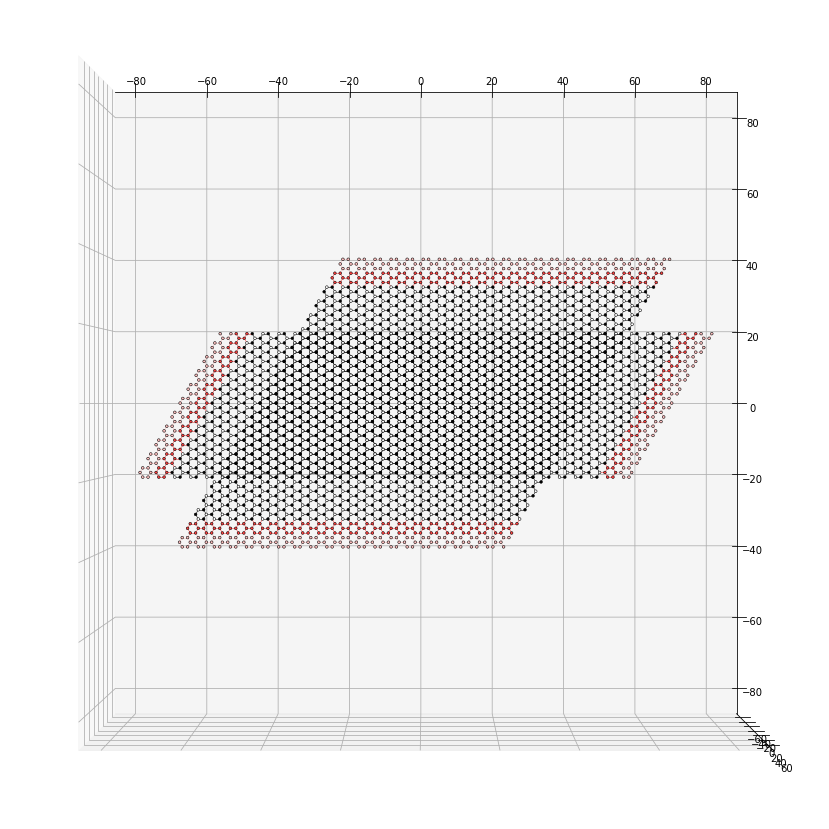

Timer: 0:00:20


/home/aleksander/anaconda3/lib/python3.8/site-packages/kwant/_plotter.py:312: RuntimeWarning: divide by zero encountered in double_scalars
  return -self.zorder3d + vs[2].mean() / cz.ptp()


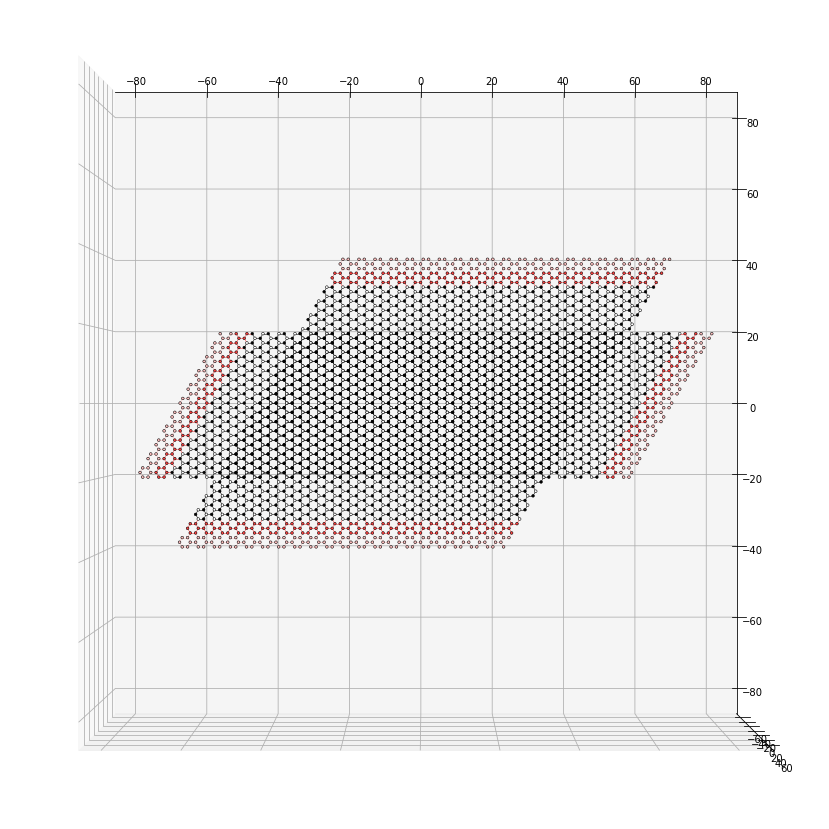

Timer: 0:00:19


In [8]:
#*************************************************** Testing ***************************************************#  

Gs_en = conductances_at_fixed_angle(energies = [0., 1.], angle = 0., extra_translations = 6,  NL = 20, NW = 10)
Gs_ang = conductances_at_fixed_energy(angles = [0., 5], energy = 0., extra_translations = 6,  NL = 20, NW = 10)